In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from collections import Counter

In [2]:
train_dir = 'data/train'
val_dir = 'data/validation'

In [3]:
# On affiche les classes et leur nombre d'images

classes = sorted(os.listdir(train_dir))
print("Classes disponibles :", classes)
images_per_class = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in classes}
print("Nombre d'images par classe :", images_per_class)

Classes disponibles : ['Acral_Lentiginous_Melanoma', 'Healthy_Nail', 'Onychogryphosis', 'blue_finger', 'clubbing', 'pitting']
Nombre d'images par classe : {'Acral_Lentiginous_Melanoma': 735, 'Healthy_Nail': 323, 'Onychogryphosis': 677, 'blue_finger': 603, 'clubbing': 767, 'pitting': 639}


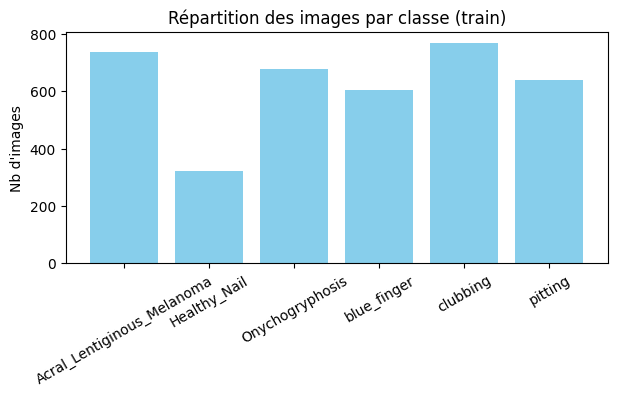

In [4]:
# Graphique de répartition
plt.figure(figsize=(7,3))
plt.bar(images_per_class.keys(), images_per_class.values(), color='skyblue')
plt.title("Répartition des images par classe (train)")
plt.ylabel("Nb d'images")
plt.xticks(rotation=30)
plt.show()


In [5]:
# On vérifie s'il y a des images corrompues ou manquantes

def is_corrupted(img_path):
    try:
        img = Image.open(img_path)
        img.verify()  # Ne lit pas, vérifie l'en-tête
        return False
    except Exception:
        return True


corrupted_files = []
for cls in classes:
    cls_folder = os.path.join(train_dir, cls)
    for img_name in os.listdir(cls_folder):
        path = os.path.join(cls_folder, img_name)
        if is_corrupted(path):
            corrupted_files.append(path)
print(f"Images corrompues détectées : {len(corrupted_files)}")

Images corrompues détectées : 0


In [6]:
# Suppression des images corrompues
for path in corrupted_files:
    os.remove(path)

In [7]:
# Vérif de doublons
from hashlib import md5
hashes = set()
duplicates = []
for cls in classes:
    cls_folder = os.path.join(train_dir, cls)
    for img_name in os.listdir(cls_folder):
        path = os.path.join(cls_folder, img_name)
        with open(path, 'rb') as f:
            img_hash = md5(f.read()).hexdigest()
        if img_hash in hashes:
            duplicates.append(path)
        else:
            hashes.add(img_hash)
print(f"Doublons détectés : {len(duplicates)}")

Doublons détectés : 0


In [8]:
for path in duplicates:
    os.remove(path)

In [9]:
# Taille moyenne des images, canaux, etc.
shapes = []
for cls in classes:
    cls_folder = os.path.join(train_dir, cls)
    img_name = os.listdir(cls_folder)[0]
    img = Image.open(os.path.join(cls_folder, img_name))
    shapes.append(img.size)
df_shapes = pd.DataFrame(shapes, columns=["Largeur", "Hauteur"])
print(df_shapes.describe())

       Largeur  Hauteur
count      6.0      6.0
mean     416.0    416.0
std        0.0      0.0
min      416.0    416.0
25%      416.0    416.0
50%      416.0    416.0
75%      416.0    416.0
max      416.0    416.0


In [10]:
def get_histogram(img_path):
    img = Image.open(img_path).resize((64, 64))
    arr = np.array(img)
    # Moyenne par canal
    r, g, b = arr[:, :, 0].mean(), arr[:, :, 1].mean(), arr[:, :, 2].mean()
    return [r, g, b]


features, y = [], []
for i, cls in enumerate(classes):
    cls_folder = os.path.join(train_dir, cls)
    for img_name in os.listdir(cls_folder)[:50]:  # Limite pour rapidité
        feat = get_histogram(os.path.join(cls_folder, img_name))
        features.append(feat)
        y.append(i)
features = np.array(features)

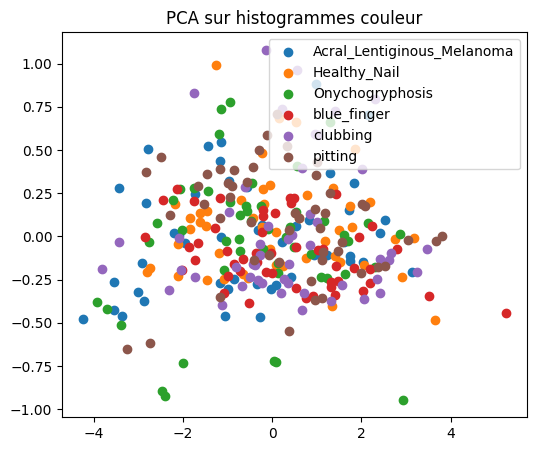

In [11]:
# Analyse exploratoire avancée : PCA
from sklearn.preprocessing import StandardScaler
features_scaled = StandardScaler().fit_transform(features)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(features_scaled)

plt.figure(figsize=(6, 5))
for i, cls in enumerate(classes):
    idx = np.where(np.array(y) == i)
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=cls)
plt.legend()
plt.title("PCA sur histogrammes couleur")
plt.show()

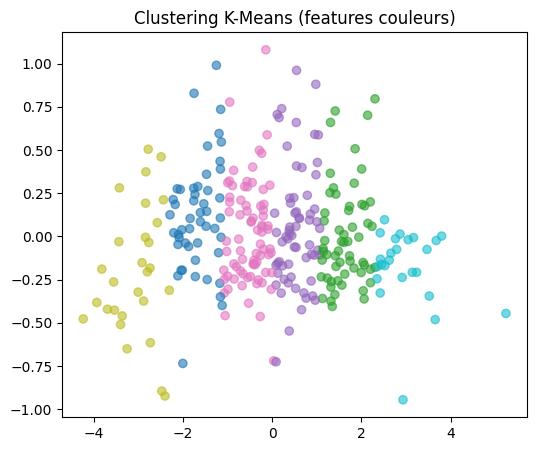

In [12]:
#  Clustering K-Means sur les features
kmeans = KMeans(n_clusters=len(classes), random_state=42)
labels_km = kmeans.fit_predict(features_scaled)

plt.figure(figsize=(6, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_km, cmap='tab10', alpha=0.6)
plt.title("Clustering K-Means (features couleurs)")
plt.show()

In [13]:
#  Préprocessing : Générateurs Keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
train_gen = ImageDataGenerator(
    rescale=1./255, rotation_range=20, width_shift_range=0.1,
    height_shift_range=0.1, zoom_range=0.1, horizontal_flip=True,
    fill_mode='nearest'
)
val_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    train_dir, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='sparse')
val_data = val_gen.flow_from_directory(
    val_dir, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='sparse')

Found 3744 images belonging to 6 classes.
Found 91 images belonging to 6 classes.
